# Two-dimensional quantum dot in a harmonic oscillator potential subject to a laser field.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

from tdhf import HartreeFock
from quantum_systems import TwoDimensionalHarmonicOscillator
from quantum_systems.time_evolution_operators import LaserField
from coupled_cluster.ccd import OATDCCD
from coupled_cluster.integrators import GaussIntegrator

In [2]:
class LaserPulse:

    def __init__(self, t_0=0, t_final=10, omega=8, strength=0.03):
        self.t_0 = t_0
        self.t_final = t_final
        self.omega = omega
        self.strength = strength

    def __call__(self, t):
        return self.strength * np.sin(self.omega * t)

In [18]:
n = 2
l = 12

radius = 8
num_grid_points = 401
omega = 0.4
mass = 1

tdho = TwoDimensionalHarmonicOscillator(n, l, radius, num_grid_points, omega=omega, mass=mass)
tdho.setup_system()

hf = HartreeFock(tdho, verbose=True)
C = hf.scf(tolerance=1e-12)
tdho.change_basis(C)

(1.52201542137+0j)
(1.50517641651+0j)
(1.50789651246+0j)
(1.50803511887+0j)
(1.50804179684+0j)
(1.50804211774+0j)
(1.50804213316+0j)
(1.5080421339+0j)
(1.50804213394+0j)
(1.50804213394+0j)
(1.50804213394+0j)
HF converged to given precision in 10 iterations
Ehf: (1.5080421339414811+0j)


In [19]:
polarization_vector = np.zeros(2)
polarization_vector[1] = 1/np.sqrt(2)
polarization_vector[1] = 1/np.sqrt(2)

laser = LaserField(
    LaserPulse(omega=8*omega, strength=1),
    polarization_vector=polarization_vector
)

tdho.set_time_evolution_operator(laser)

In [20]:
cc_kwargs = dict(verbose=True)
theta_t = 0.1
theta_l = 0.1
tol = 1e-4

integrator = GaussIntegrator(np=np, eps=1e-10)
oatdccd = OATDCCD(tdho, np=np, integrator=integrator, **cc_kwargs)

t_kwargs = dict(theta=theta_t, tol=tol)
l_kwargs = dict(theta=theta_l, tol=tol)

oatdccd.compute_ground_state(t_kwargs=t_kwargs, l_kwargs=l_kwargs)
print("Ground state CCD energy: {0}".format(oatdccd.compute_ground_state_energy()))

Iteration: 0	Diff (t): [100]
Iteration: 1	Diff (t): [0.030960234812620835]
Iteration: 2	Diff (t): [0.012648482876413542]
Iteration: 3	Diff (t): [0.0058408454276125954]
Iteration: 4	Diff (t): [0.0027862018228617391]
Iteration: 5	Diff (t): [0.0013367007770380412]
Iteration: 6	Diff (t): [0.00064153751717213603]
Iteration: 7	Diff (t): [0.00030779003783831804]
Iteration: 8	Diff (t): [0.00014762076256849554]
Iteration: 9	Diff (t): [7.0785803766237887e-05]
Iteration: 0	Diff (l): [100]
Iteration: 1	Diff (l): [0.017593977231808638]
Iteration: 2	Diff (l): [0.0087890997226033885]
Iteration: 3	Diff (l): [0.0042630609786810658]
Iteration: 4	Diff (l): [0.0020544133006040188]
Iteration: 5	Diff (l): [0.00098809878613267954]
Iteration: 6	Diff (l): [0.00047479511393347384]
Iteration: 7	Diff (l): [0.00022800655307639306]
Iteration: 8	Diff (l): [0.00010944447721339401]
Iteration: 9	Diff (l): [5.2516077025999142e-05]
Ground state CCD energy: (1.3931468809073209+0j)


In [21]:
rho = oatdccd.compute_ground_state_particle_density()

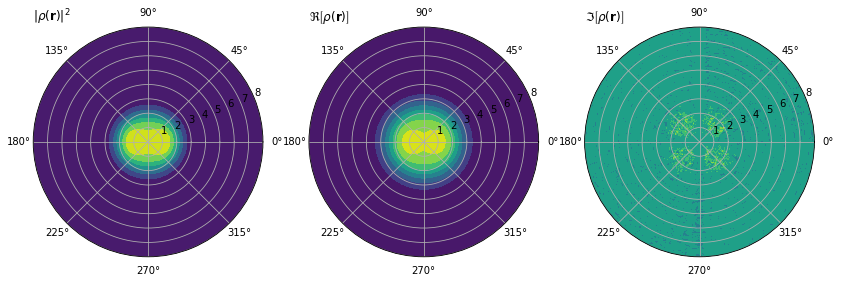

In [22]:
fig = plt.figure(figsize=(14, 10))

ax = fig.add_subplot(1, 3, 1, polar=True)
ax.set_title(r"$|\rho(\mathbf{r})|^2$", loc="left")
plt.contourf(tdho.T, tdho.R, np.abs(rho * rho.conj()))

ax = fig.add_subplot(1, 3, 2, polar=True)
ax.set_title(r"$\Re\left[\rho(\mathbf{r})\right]$", loc="left")
plt.contourf(tdho.T, tdho.R, rho.real)

ax = fig.add_subplot(1, 3, 3, polar=True)
ax.set_title(r"$\Im\left[\rho(\mathbf{r})\right]$", loc="left")
plt.contourf(tdho.T, tdho.R, rho.imag)
plt.show()

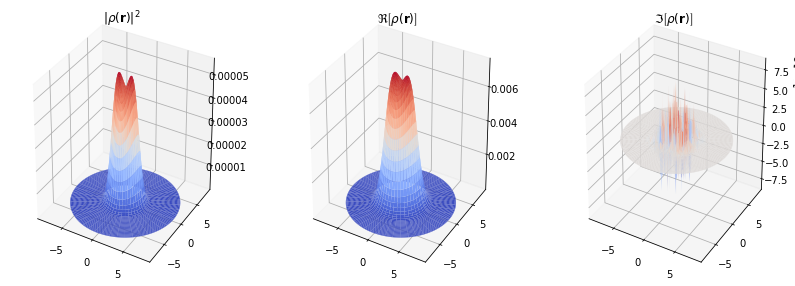

In [23]:
X, Y = tdho.R * np.cos(tdho.T), tdho.R * np.sin(tdho.T)

fig = plt.figure(figsize=(14, 5))
ax = fig.add_subplot(1, 3, 1, projection="3d")

ax.plot_surface(X, Y, np.abs(rho * rho.conj()), cmap=cm.coolwarm)
plt.title(r"$|\rho(\mathbf{r})|^2$")

#fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 3, 2, projection="3d")

ax.plot_surface(X, Y, rho.real, cmap=cm.coolwarm)
plt.title(r"$\Re\left[\rho(\mathbf{r})\right]$")

#fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 3, 3, projection="3d")

ax.plot_surface(X, Y, rho.imag, cmap=cm.coolwarm)
plt.title(r"$\Im\left[\rho(\mathbf{r})\right]$")

plt.show()

In [24]:
oatdccd.set_initial_conditions()

In [25]:
num_timesteps = 801
t_end = 8
time_points = np.linspace(0, t_end, num_timesteps)

In [26]:
psi_overlap = np.zeros(num_timesteps, dtype=np.complex128)
td_energies = np.zeros(num_timesteps, dtype=np.complex128)

psi_overlap[0] = oatdccd.compute_time_dependent_overlap()
td_energies[0] = oatdccd.compute_energy()

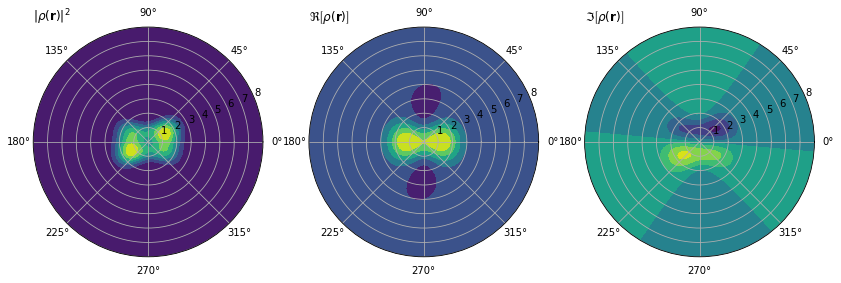

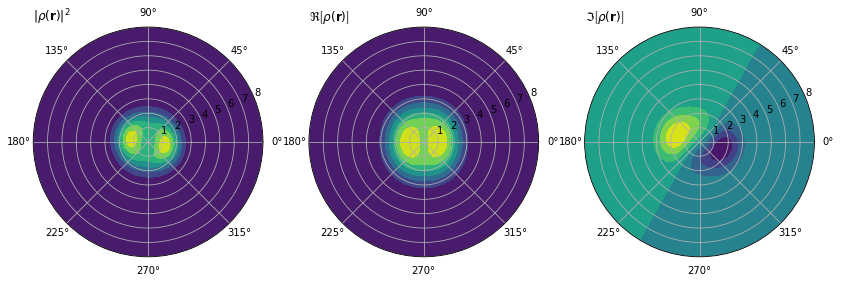

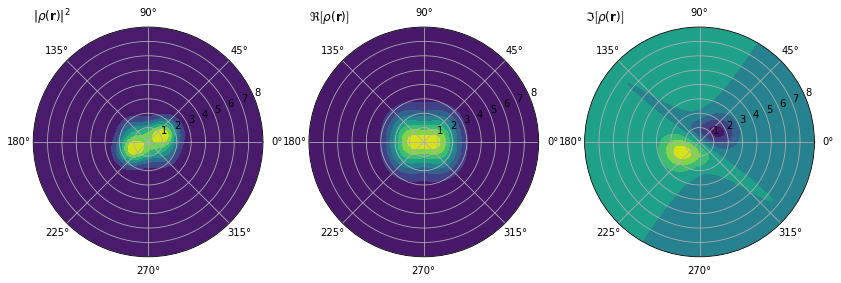

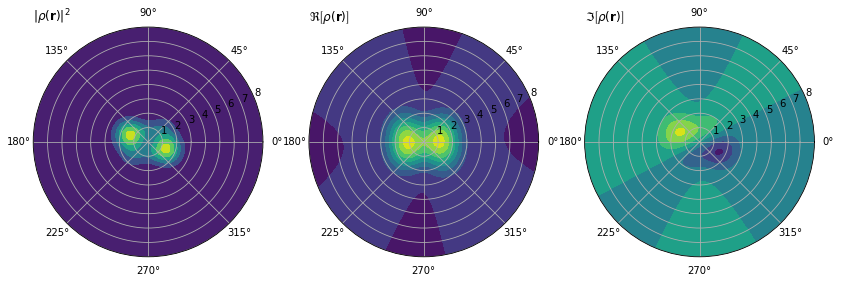

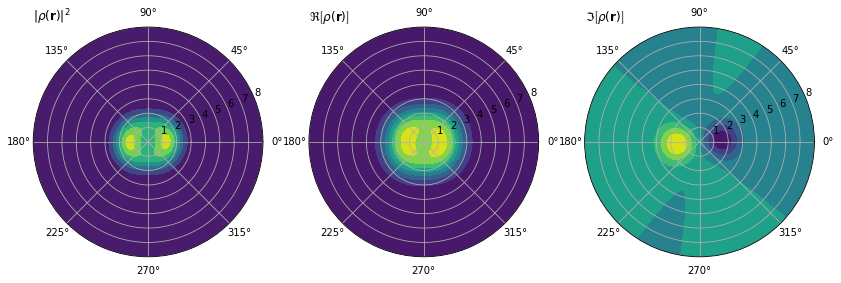

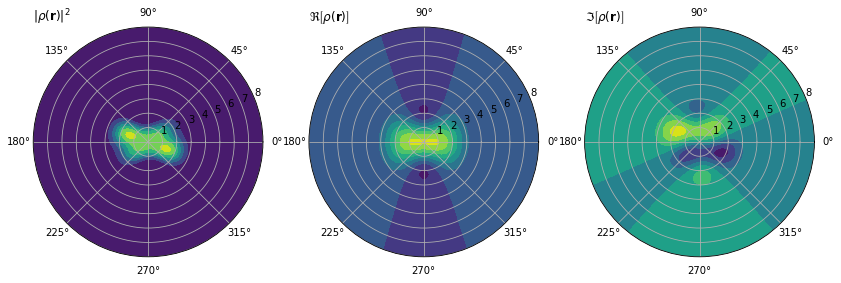

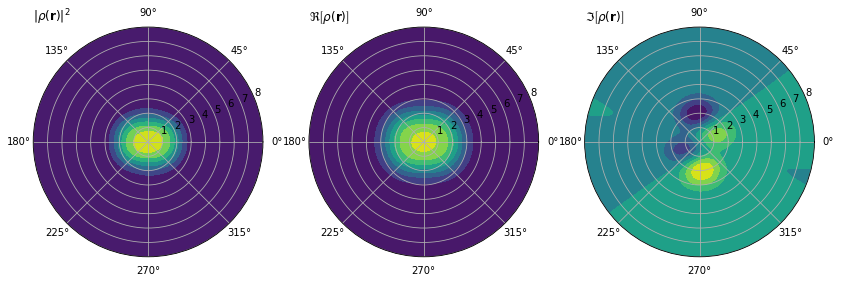

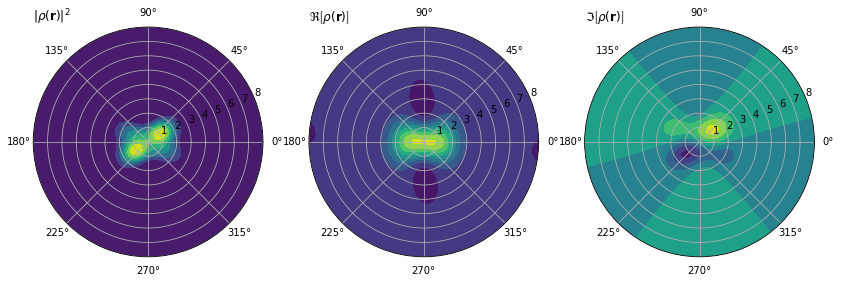

In [27]:
step_final = num_timesteps - 1
plot_3d = False
plot_step_freq = 100

for i, amp in enumerate(oatdccd.solve(time_points)):
    step = i + 1
    print(100 * " ", end="\r")
    print(f"step = {step} / {step_final}", end="\r")
    psi_overlap[i + 1] = oatdccd.compute_time_dependent_overlap()
    td_energies[i + 1] = oatdccd.compute_energy()

    if not plot_3d and step % plot_step_freq == 0:
        rho = oatdccd.compute_particle_density()

        fig = plt.figure(figsize=(14, 10))

        ax = fig.add_subplot(1, 3, 1, polar=True)
        ax.set_title(r"$|\rho(\mathbf{r})|^2$", loc="left")
        plt.contourf(tdho.T, tdho.R, np.abs(rho * rho.conj()))

        ax = fig.add_subplot(1, 3, 2, polar=True)
        ax.set_title(r"$\Re\left[\rho(\mathbf{r})\right]$", loc="left")
        plt.contourf(tdho.T, tdho.R, rho.real)

        ax = fig.add_subplot(1, 3, 3, polar=True)
        ax.set_title(r"$\Im\left[\rho(\mathbf{r})\right]$", loc="left")
        plt.contourf(tdho.T, tdho.R, rho.imag)

        plt.show()

    if plot_3d and step % plot_step_freq == 0:
        rho = oatdccd.compute_particle_density()

        fig = plt.figure(figsize=(14, 5))
        ax = fig.add_subplot(1, 3, 1, projection="3d")

        ax.plot_surface(X, Y, np.abs(rho * rho.conj()), cmap=cm.coolwarm)
        plt.title(r"$|\rho(\mathbf{r})|^2$")

        #fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(1, 3, 2, projection="3d")

        ax.plot_surface(X, Y, rho.real, cmap=cm.coolwarm)
        plt.title(r"$\Re\left[\rho(\mathbf{r})\right]$")

        #fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(1, 3, 3, projection="3d")

        ax.plot_surface(X, Y, rho.imag, cmap=cm.coolwarm)
        plt.title(r"$\Im\left[\rho(\mathbf{r})\right]$")

        plt.show()

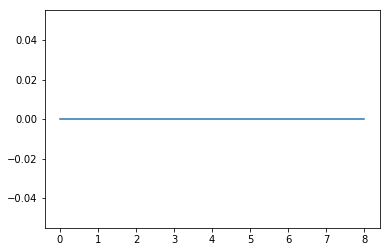

In [28]:
plt.plot(time_points, psi_overlap.real)
plt.show()

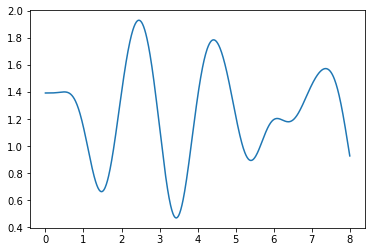

In [29]:
plt.plot(time_points, td_energies.real)
plt.show()

In [30]:
rho = oatdccd.compute_particle_density()

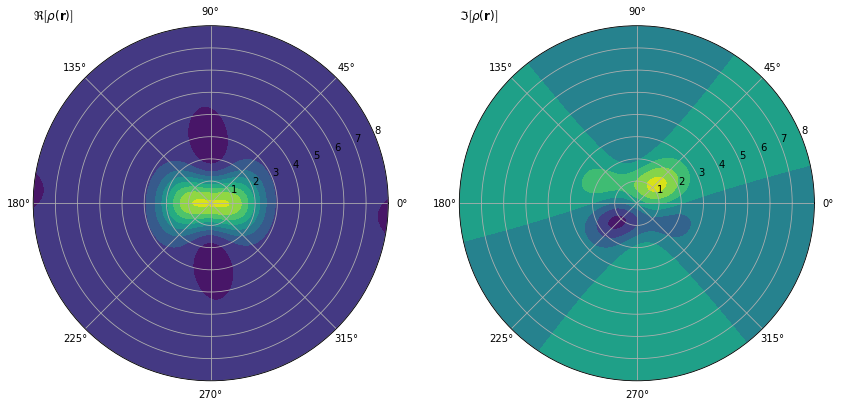

In [31]:
fig = plt.figure(figsize=(14, 10))

ax = fig.add_subplot(1, 2, 1, polar=True)
ax.set_title(r"$\Re\left[\rho(\mathbf{r})\right]$", loc="left")
plt.contourf(tdho.T, tdho.R, rho.real)

ax = fig.add_subplot(1, 2, 2, polar=True)
ax.set_title(r"$\Im\left[\rho(\mathbf{r})\right]$", loc="left")
plt.contourf(tdho.T, tdho.R, rho.imag)
plt.show()

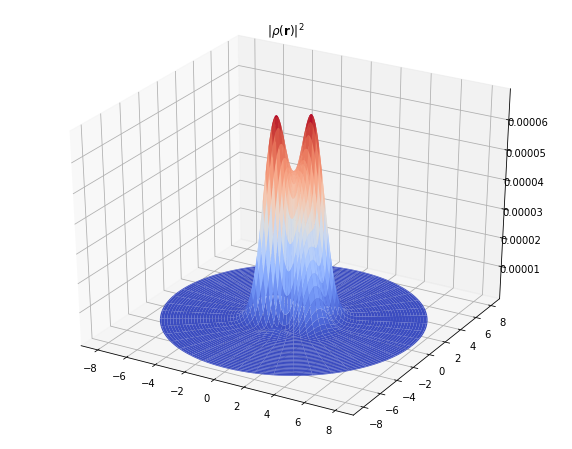

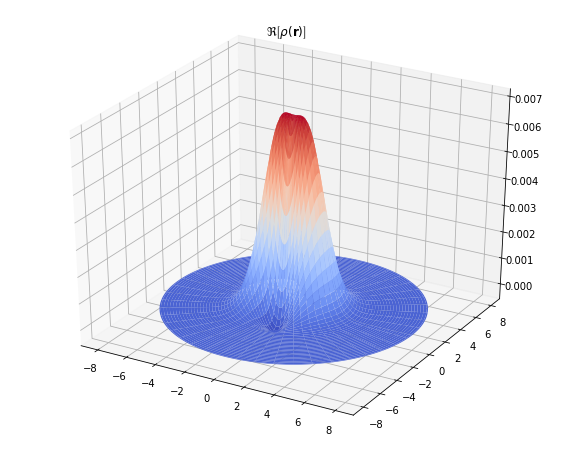

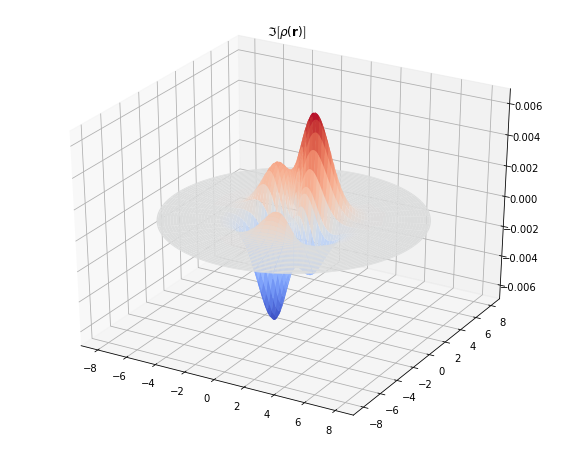

In [32]:
X, Y = tdho.R * np.cos(tdho.T), tdho.R * np.sin(tdho.T)

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(X, Y, np.abs(rho * rho.conj()), cmap=cm.coolwarm)
plt.title(r"$|\rho(\mathbf{r})|^2$")

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(X, Y, rho.real, cmap=cm.coolwarm)
plt.title(r"$\Re\left[\rho(\mathbf{r})\right]$")

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")

ax.plot_surface(X, Y, rho.imag, cmap=cm.coolwarm)
plt.title(r"$\Im\left[\rho(\mathbf{r})\right]$")

plt.show()